### CMB Assigment 2 Program ###

In [1]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import requests
sns.set(style="darkgrid")

Create Pandas Dataframe

In [2]:
#df = pd.read_csv("data/21-12-23_complete.csv")
data_folder = "/Users/Fabian/Desktop/"
df = pd.read_csv(data_folder + "test.csv")
#df = pd.read_csv("data/2022-01-04_complete.csv")
print(df)
print(df)
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


           No.                        Time        Source     Destination  \
0            1  2022-01-04 16:44:06.405328  192.168.0.22  188.164.238.26   
1            2  2022-01-04 16:44:06.418960  192.168.0.22  188.164.238.26   
2            3  2022-01-04 16:44:14.010838  192.168.0.22  188.164.238.26   
3            4  2022-01-04 16:44:14.031386  192.168.0.22  188.164.238.26   
4            5  2022-01-04 16:44:14.035643  192.168.0.22  188.164.238.26   
...        ...                         ...           ...             ...   
226803  226804  2022-01-05 16:44:05.641075  192.168.0.22  188.164.238.26   
226804  226805  2022-01-05 16:44:05.660090  192.168.0.22  188.164.238.26   
226805  226806  2022-01-05 16:44:05.677264  192.168.0.22  188.164.238.26   
226806  226807  2022-01-05 16:44:05.700215  192.168.0.22  188.164.238.26   
226807  226808  2022-01-05 16:44:05.701142  192.168.0.22  188.164.238.26   

       Protocol  Length                                               Info  
0         

In [3]:
# helper functions
def utcEntryToTimestamp(entry):
    row_entry = entry.split(".")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.loc[0])
# print(df.loc[0].at['Time'])

1641311046

### Protocol packet distribution ###

Protocol
DNS            1385
HTTP            482
HTTP/JSON       580
TCP          172660
TLSv1             8
TLSv1.2       51693
Name: Source, dtype: int64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_85775/1857181538.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


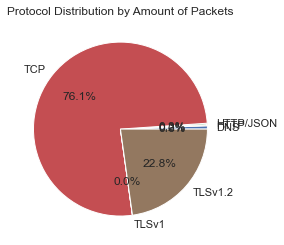

In [4]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

Protocol
DNS            132349
HTTP           103953
HTTP/JSON      280055
TCP           9583876
TLSv1            1592
TLSv1.2      10109785
Name: Length, dtype: int64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_85775/3895533642.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


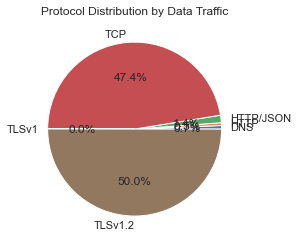

In [5]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
plt.title('Protocol Distribution by Data Traffic')
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type ###

Protocol
DNS           95.558845
HTTP         215.670124
HTTP/JSON    482.853448
TCP           55.507216
TLSv1        199.000000
TLSv1.2      195.573579
Name: Length, dtype: float64


/var/folders/px/zjht8g6j4bvglsnf70rp41d80000gn/T/ipykernel_85775/212732153.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


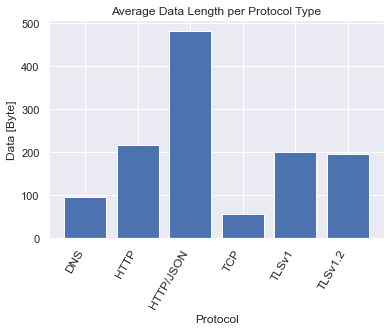

In [6]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Average Data Length per Protocol Type')
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

### Source addresses ###

In [7]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

Source
192.168.0.1         682
192.168.0.121     25202
192.168.0.2          28
192.168.0.200      2891
192.168.0.22     196379
192.168.0.88         54
192.168.0.9        1572
Name: Time, dtype: int64
Destination
88.221.139.67          8
192.168.0.9            8
54.220.43.22          12
54.216.189.126        12
52.209.43.253         12
81.169.210.193        13
92.122.24.124         15
34.250.121.83         22
192.168.0.22          25
192.168.0.2           25
104.121.176.87        26
192.168.0.88          54
192.168.0.1          703
34.245.145.101      1457
85.214.250.60       3198
192.168.0.121       3461
85.214.67.97        3603
81.169.180.11       8788
85.214.202.106      9014
188.164.238.26    196352
Name: Time, dtype: int64


### DNS requests ###

In [8]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


server.chillibits.com               528
pool.ntp.org                         54
0.debian.pool.ntp.org                54
0.pool.ntp.org                       24
api.sensor.community                 17
api-rrd.madavi.de                    15
msmetrics.ws.sonos.com                3
firmware.sensor.community             2
update-timezone.sonos.com             1
service-catalog.ws.sonos.com          1
update.sonos.com                      1
update-firmware.sonos.com             1
www.mvg.de                            1
feature-config.sslauth.sonos.com      1
Name: Info, dtype: int64


### IP Wordlwide location

In [25]:
df_destinations =  df['Destination'].unique()

for dest in df_destinations[:10]: # 10 entries limit for now
    if dest.startswith("192.168"):
            continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(dest)
    r = requests.get(url, headers=headers)
    print(r.json() )  


{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '188.164.238.26', 'ip': '188.164.238.26', 'rdns': '188.164.238.26', 'asn': 198145, 'isp': 'SWM Services GmbH', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Bavaria', 'region_code': 'BY', 'city': 'Munich', 'postal_code': '80331', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 48.1336, 'longitude': 11.5658, 'metro_code': None, 'timezone': 'Europe/Berlin', 'datetime': '2022-01-16 17:58:08'}}}
{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '34.245.145.101', 'ip': '34.245.145.101', 'rdns': 'ec2-34-245-145-101.eu-west-1.compute.amazonaws.com', 'asn': 16509, 'isp': 'AMAZON-02', 'country_name': 'Ireland', 'country_code': 'IE', 'region_name': 'Leinster', 'region_code': 'L', 'city': 'Dublin', 'postal_code': 'D02', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 53.3382, 'longitude': -6.2591, 'metro_code': N

### Data traffic over time ###

In [ ]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.loc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration

print('from ', df_time_mod.loc[0].at['Time'], " to ", df_time_mod.iloc[-1].at['Time'])

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

x_values_packets = list(range(first_entry, last_entry + 1))
print(len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - first_entry] += 1
    length_packets[ts - first_entry] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()